# Homework 2
## IDS 576 <br>
Name: Isaac Salvador <br>
Email: isalva2@uic.edu <br>
UIN: 6669845132 <br>

Name: Ahreum Kim <br>
Email: akim239@uic.edu <br>
UIN: 653241895 <br>

Name: Sadjad Bazarnovi <br>
Email: sbazar3@uic.edu <br>
UIN: 679314994 <br>

## 2. Movie embeddings

### Data Importation
First, download the movielens (small) [dataset](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip) as `pandas.DataFrame` objects. 

In [27]:
import torch
from torch import mps
import numpy as np
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# make torch deterministic for reproducibility
torch.manual_seed(576)

# set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Torch Device:", device)

Torch Device: mps


In [1]:
import pandas as pd

path = "Misc_files/movielens_data/ml-latest-small/"

# load movies and ratings DataFrames
movies = pd.read_csv(path+"movies.csv", header=0)
ratings = pd.read_csv(path+"ratings.csv", header=0)

We can then use the `head()` method to see the raw format of these `DataFrame` objects.

In [2]:
n_movies = len(movies)

print(f"Number of Unique Movies: {n_movies}")
movies.head()

Number of Unique Movies: 9742


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
n_ratings = len(ratings)
n_users = ratings.userId.nunique()
n_rated_movies = ratings.movieId.nunique()

print(f"Number of Ratings: {n_ratings}\nNumber of Users: {n_users}\nNumber of Unique Rated Movies: {n_rated_movies}")
ratings.head()

Number of Ratings: 100836
Number of Users: 610
Number of Unique Rated Movies: 9724


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Upon inspection of the raw data we note that of the 9,742 movies in the `movies` DataFrame, only 9,724 movies have been rated.

### Preprocessing

#### Embedding Matrix $X$
To obtain the concurrent number of likes $X_{i,j}$ we must first binary encode (`0` or `1`) each `"rating"` in the `ratings` DataFrame. Let us encode the value of liking a movie for each review as such

$$ \text{Liked}(\text{Rating}) =
    \begin{cases}
        1 & \text{if Rating}\geq 4\\
        0 & \text{otherwise}
    \end{cases}$$

and store these values in a new `"liked"` column. We can subsequently drop the unnecessary `rating` and `timestamp` columns after this process.

In [5]:
# create liked column
ratings["liked"] = np.where(ratings["rating"] >= 4, 1, 0)

# drop columns
ratings.drop(["rating", "timestamp"], axis=1, inplace=True)

We next create the `movie_ratings` DataFrame by joing the `movies` and `ratings` DataFrames. Setting the `merge` method parameter `how="left"` ensures that the original number of movies, 9,742, are maintained after the join.

In [6]:
# left join on movieId
movie_ratings = pd.merge(movies, ratings, how="left", on="movieId").reset_index()

A user-likes interaction matrix can then be constructed using the `pivot_table` method, whose rows correspond to the number of unique users `n_users` and columns correspond to the number of unique movies `n_movies` from the original data. This results in a sparse matrix whose rows summarize each users liked movies.

In [7]:
# pivot table on userId
user_likes = movie_ratings.pivot_table(values="liked", index="userId", columns="movieId", dropna=False, fill_value=0)

user_likes

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1.0,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
607.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
608.0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Embedding matrix $X$ can now be constructed as the inner (dot) product of the transpose of `user_likes ` and itself. Element $X_{ij} \in X$ corresponds to the number of users that like both movie $i$ and $j$.

In [8]:
# convert to numpy ndarray for dot product computation
user_likes_array = user_likes.to_numpy()

# create X
X_embedding = np.dot(user_likes_array.T, user_likes_array)

# fill diagonals of X with zeros
np.fill_diagonal(X_embedding, 0)

# display as DataFrame for clarity
X_display = pd.DataFrame(X_embedding, index=movies.movieId, columns = movies.movieId)

X_display

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,21,11,0,7,27,7,1,4,19,...,0,0,0,0,0,0,0,0,0,0
2,21,0,5,0,4,8,6,0,0,9,...,0,0,0,0,0,0,0,0,0,0
3,11,5,0,0,4,4,5,1,2,3,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,7,4,4,0,0,3,4,1,1,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
193583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model Architecture
With preprocessing completed, we convert embedding $X$ into a `torch` tensor object and construct cost function $c$.

In [10]:
X = torch.tensor(X_embedding, dtype = torch.float32)

We implement the below cost function:
$$c(v_1,\ldots, v_M)=\sum_{i=1}^M\sum_{j=1}^M 1_{[i\neq j]}(v_i^T v_j-X_{i,j})^2$$
by creating a superclass of the `torch` `nn.Module` class.

In [11]:
import torch.nn as nn

class cost_function(nn.Module):
    def __init__(self):
        super().__init__()
    
    @ classmethod
    def forward(self, v, X):
        # perform main cost function
        costs = ((1 - torch.eye(n_movies)) * (torch.mm(v.t(), v) - X)**2).sum()
        
        return costs

### Training
We can now devise a training loop `train()` and training schema to evaluate different hyperparameters on our cost function.

In [31]:
# training loop
def train(model, v, X, optimizer, n_epochs=100, verbose = 10):
    
    costs = []
    
    for epoch in tqdm(range(n_epochs)):
        # forward pass
        cost = model.forward(v, X)
        
        # backward pass
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        costs.append(cost.item())
        
        if epoch % verbose == 0:
            print(f"Epoch: {epoch}\tCost: {cost: .5f}")
            
    return costs

# hyperparameters to evaluate
learning_rates = [[1e-5, 1e-6, 1e-7], [1e-4, 1e-3, 1e-1]]
optimizers = ['SGD', 'Adam']

# tracking objects
results = []
trained_vectors = []

# set for epochs
epochs = 20

# Loop over hyperparameters
for optimizer_name in optimizers:
    for lr in learning_rates[optimizers.index(optimizer_name)]: # This is because learning rates are different for each optimizer
        
        # Print configuration hyperparameters
        print(f"Model Configuration:\noptimizer: {optimizer_name}\nlearning rate: {lr}\n")
        
        # Create a new model for each configuration
        v = torch.normal(mean=0, std=0.5, size=(n_movies, n_movies), requires_grad=True)
        model = cost_function()
        model.to(device)

        # Define the optimizer based on the chosen name
        if optimizer_name == 'Adam':
            optimizer = optim.Adam([v], lr=lr)
        elif optimizer_name == 'SGD':
            optimizer = optim.SGD([v], lr=lr, momentum=0.9)

        # Train the model and store the history
        history = train(model, v, X, optimizer, n_epochs=epochs, verbose = 1)

        # Save vectors
        trained_vectors.append(v.detach())

        # Store the results
        result = {
            'learning_rate': lr,
            'optimizer': optimizer_name,
            'loss': history
        }
        
        results.append(result)
        
        print("\n")

Model Configuration:
optimizer: SGD
learning rate: 1e-05



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0	Cost:  57846087680.00000
Epoch: 1	Cost:  25925857280.00000
Epoch: 2	Cost:  9094426624.00000
Epoch: 3	Cost:  5194097152.00000
Epoch: 4	Cost:  4453842432.00000
Epoch: 5	Cost:  3882238976.00000
Epoch: 6	Cost:  4329784320.00000
Epoch: 7	Cost:  6635393024.00000
Epoch: 8	Cost:  8680079360.00000
Epoch: 9	Cost:  8545677824.00000
Epoch: 10	Cost:  7166279680.00000
Epoch: 11	Cost:  5767490560.00000
Epoch: 12	Cost:  4685248512.00000
Epoch: 13	Cost:  3825792000.00000
Epoch: 14	Cost:  3105590784.00000
Epoch: 15	Cost:  2487401728.00000
Epoch: 16	Cost:  1978133376.00000
Epoch: 17	Cost:  1614578048.00000
Epoch: 18	Cost:  1403468800.00000
Epoch: 19	Cost:  1291588480.00000


Model Configuration:
optimizer: SGD
learning rate: 1e-06



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0	Cost:  57864118272.00000
Epoch: 1	Cost:  53506084864.00000
Epoch: 2	Cost:  46263369728.00000
Epoch: 3	Cost:  37891858432.00000
Epoch: 4	Cost:  29815445504.00000
Epoch: 5	Cost:  22868414464.00000
Epoch: 6	Cost:  17346486272.00000
Epoch: 7	Cost:  13193802752.00000
Epoch: 8	Cost:  10187829248.00000
Epoch: 9	Cost:  8065057792.00000
Epoch: 10	Cost:  6585990656.00000
Epoch: 11	Cost:  5558555136.00000
Epoch: 12	Cost:  4839370240.00000
Epoch: 13	Cost:  4326042112.00000
Epoch: 14	Cost:  3947599872.00000
Epoch: 15	Cost:  3656063488.00000
Epoch: 16	Cost:  3419867648.00000
Epoch: 17	Cost:  3218896896.00000
Epoch: 18	Cost:  3040728320.00000
Epoch: 19	Cost:  2877847808.00000


Model Configuration:
optimizer: SGD
learning rate: 1e-07



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0	Cost:  57829216256.00000
Epoch: 1	Cost:  57380368384.00000
Epoch: 2	Cost:  56538959872.00000
Epoch: 3	Cost:  55364489216.00000
Epoch: 4	Cost:  53916807168.00000
Epoch: 5	Cost:  52253724672.00000
Epoch: 6	Cost:  50429288448.00000
Epoch: 7	Cost:  48492527616.00000
Epoch: 8	Cost:  46486769664.00000
Epoch: 9	Cost:  44449308672.00000
Epoch: 10	Cost:  42411446272.00000
Epoch: 11	Cost:  40398749696.00000
Epoch: 12	Cost:  38431494144.00000
Epoch: 13	Cost:  36525236224.00000
Epoch: 14	Cost:  34691383296.00000
Epoch: 15	Cost:  32937781248.00000
Epoch: 16	Cost:  31269339136.00000
Epoch: 17	Cost:  29688543232.00000
Epoch: 18	Cost:  28195932160.00000
Epoch: 19	Cost:  26790545408.00000


Model Configuration:
optimizer: Adam
learning rate: 0.0001



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0	Cost:  57861603328.00000
Epoch: 1	Cost:  57809428480.00000
Epoch: 2	Cost:  57757310976.00000
Epoch: 3	Cost:  57705234432.00000
Epoch: 4	Cost:  57653202944.00000
Epoch: 5	Cost:  57601228800.00000
Epoch: 6	Cost:  57549295616.00000
Epoch: 7	Cost:  57497415680.00000
Epoch: 8	Cost:  57445588992.00000
Epoch: 9	Cost:  57393811456.00000
Epoch: 10	Cost:  57342078976.00000
Epoch: 11	Cost:  57290407936.00000
Epoch: 12	Cost:  57238781952.00000
Epoch: 13	Cost:  57187213312.00000
Epoch: 14	Cost:  57135697920.00000
Epoch: 15	Cost:  57084235776.00000
Epoch: 16	Cost:  57032822784.00000
Epoch: 17	Cost:  56981475328.00000
Epoch: 18	Cost:  56930177024.00000
Epoch: 19	Cost:  56878936064.00000


Model Configuration:
optimizer: Adam
learning rate: 0.001



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0	Cost:  57817743360.00000
Epoch: 1	Cost:  57298370560.00000
Epoch: 2	Cost:  56783540224.00000
Epoch: 3	Cost:  56273293312.00000
Epoch: 4	Cost:  55767658496.00000
Epoch: 5	Cost:  55266689024.00000
Epoch: 6	Cost:  54770397184.00000
Epoch: 7	Cost:  54278807552.00000
Epoch: 8	Cost:  53791940608.00000
Epoch: 9	Cost:  53309820928.00000
Epoch: 10	Cost:  52832452608.00000
Epoch: 11	Cost:  52359839744.00000
Epoch: 12	Cost:  51891998720.00000
Epoch: 13	Cost:  51428917248.00000
Epoch: 14	Cost:  50970603520.00000
Epoch: 15	Cost:  50517041152.00000
Epoch: 16	Cost:  50068221952.00000
Epoch: 17	Cost:  49624137728.00000
Epoch: 18	Cost:  49184776192.00000
Epoch: 19	Cost:  48750104576.00000


Model Configuration:
optimizer: Adam
learning rate: 0.1



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0	Cost:  57831776256.00000
Epoch: 1	Cost:  24206647296.00000
Epoch: 2	Cost:  11583097856.00000
Epoch: 3	Cost:  6867374592.00000
Epoch: 4	Cost:  5088110080.00000
Epoch: 5	Cost:  4321560576.00000
Epoch: 6	Cost:  3866012928.00000
Epoch: 7	Cost:  3477851392.00000
Epoch: 8	Cost:  3092493824.00000
Epoch: 9	Cost:  2715210240.00000
Epoch: 10	Cost:  2367997184.00000
Epoch: 11	Cost:  2064991488.00000
Epoch: 12	Cost:  1808596992.00000
Epoch: 13	Cost:  1597054208.00000
Epoch: 14	Cost:  1423815296.00000
Epoch: 15	Cost:  1277813376.00000
Epoch: 16	Cost:  1149398528.00000
Epoch: 17	Cost:  1033291648.00000
Epoch: 18	Cost:  927278208.00000
Epoch: 19	Cost:  829560448.00000




In [32]:
import pickle

# Save the results to a file
with open('results.pkl', 'wb') as results_file:
    pickle.dump(results, results_file)

# Save the trained vectors to a file
with open('trained_vectors.pkl', 'wb') as vectors_file:
    pickle.dump(trained_vectors, vectors_file)

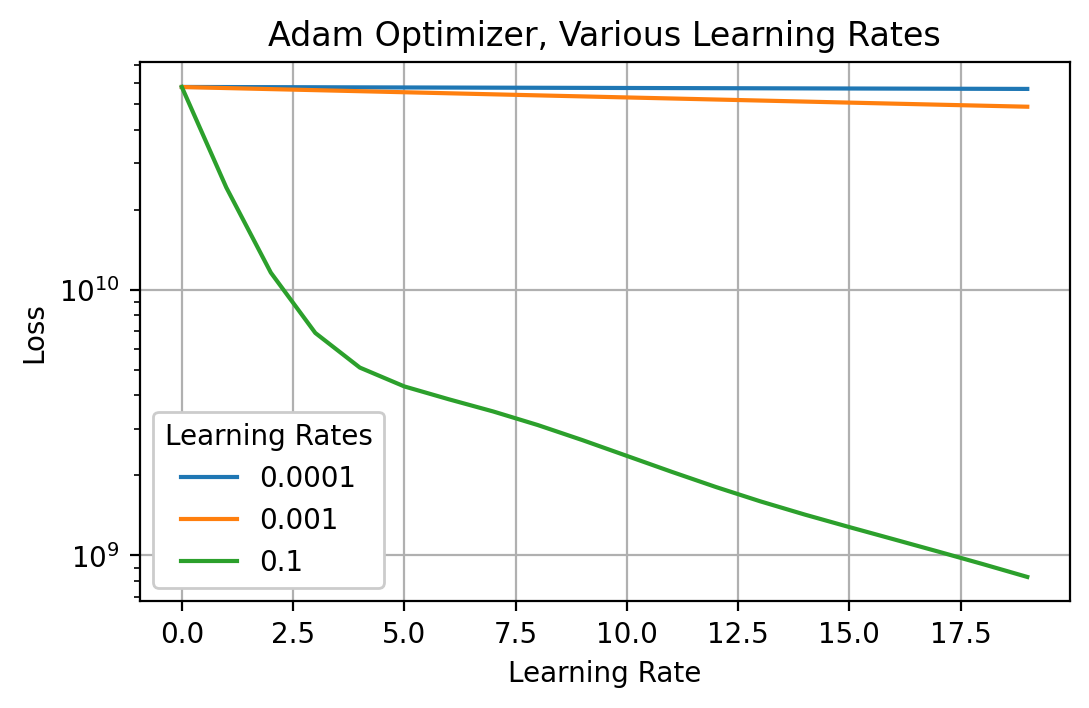

In [37]:

def plot_losses(results):
    
    fig, ax = plt.subplots(figsize=(6,3.5), dpi=200)
    
    optimizer_name = results[0]["optimizer"]
    
    ax.set_title(f"{optimizer_name} Optimizer, Various Learning Rates")
    
    for result in results:
        ax.plot(result["loss"], label=result["learning_rate"])

    # Add labels and legend
    ax.set_xlabel('Epochs') # I changed it from Learning rate to epochs
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    legend = ax.legend(title='Learning Rates', loc='best')
    legend.get_frame().set_alpha(1.0)

    # Show the plot
    ax.grid(True)

plot_losses(results[3:])

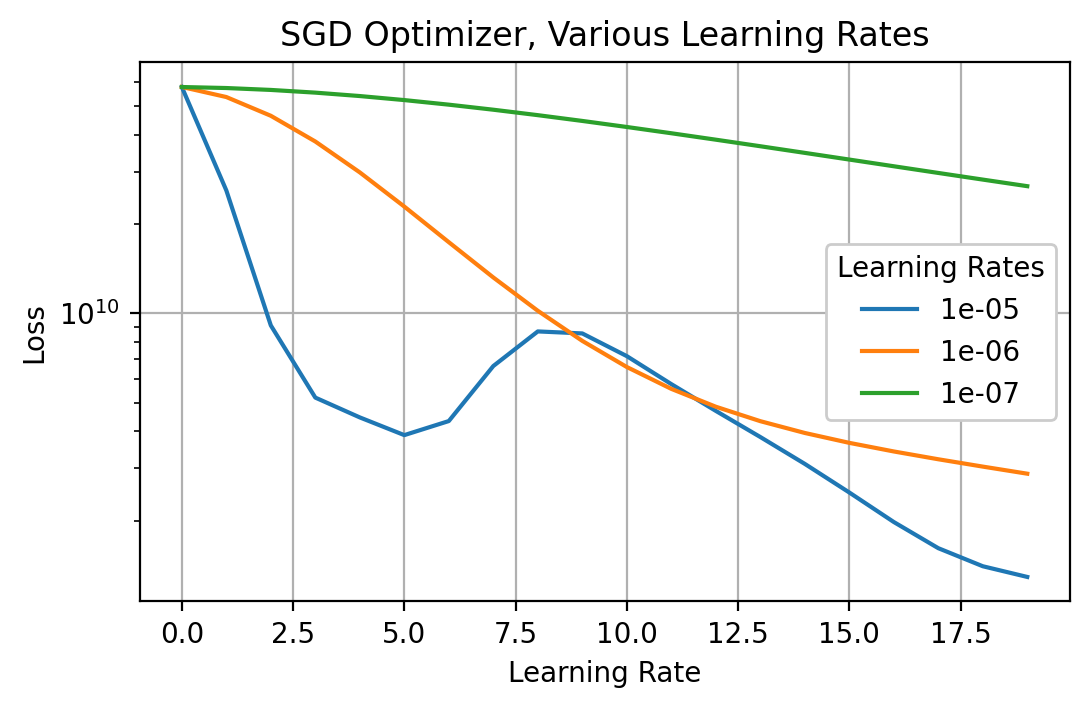

In [36]:
plot_losses(results[:3])

## Functions to recommend top N movies
We defined a function to recommend top N movies based on input movies

It first finds the indices of the input movies in the list of all movie titles.
Next, it calculates the average similarity scores for the input movies by taking the mean of the cosine similarity scores of their embeddings.
The code then excludes the input movies from consideration by setting their similarity scores to a negative value.
It identifies the top N recommended movies by sorting the similarity scores and selecting the top N indices.
Finally, it retrieves the names of the recommended movies based on the indices and returns them.

In [43]:
# Calculate movie similarities using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# Function to recommend top N movies based on input movies
def recommend_movies(input_movies, movie_names, movie_similarities, top_n=10):
    # Find the indices of input movies
    input_indices = [movie_names.index(movie) for movie in input_movies]

    # Calculate the average similarity scores for input movies
    input_similarity_scores = np.mean(movie_similarities[input_indices], axis=0)

    # Exclude input movies from consideration
    input_similarity_scores[input_indices] = -1.0  # Set similarity score to a negative value

    # Get indices of top N recommended movies
    top_indices = np.argsort(input_similarity_scores)[-top_n:][::-1]

    # Get the names of recommended movies
    recommended_movies = [movie_names[i] for i in top_indices]

    return recommended_movies

In [44]:
def get_recommendation(movies, embedding):

    # Calculate cosine similarity between movie embeddings
    movie_similarities = cosine_similarity(embedding)

    # The input movies
    input_movies = ["Apollo 13 (1995)", "Toy Story (1995)", "Home Alone (1990)"]

    # Get recommended movies and print the results
    for input_movie in input_movies:
        recommended_movies = recommend_movies([input_movie], movies['title'].tolist(), movie_similarities)
        print(f"Recommended Movies for '{input_movie}':")
        for i, movie in enumerate(recommended_movies, start=1):
            print(f"{i}. {movie}")
        print()

## Recommend top 10 movies
given movies (a) Apollo 13, (b) Toy Story, and (c) Home Alone. 

The reuslts are below. The code prints the recommended movies given each three of the movies along with a header that indicates the learning rate and optimizer used for the embedding.

In [53]:
learning_rates = [[1e-5, 1e-6, 1e-7], [1e-4, 1e-3, 1e-1]]
optimizers = ['SGD', 'Adam']

headers = []  # The list of trained vectors
trained_index = 0
for optimizer in optimizers:
    for lr in learning_rates[optimizers.index(optimizer)]:
        header = f"The result of Learning Rate: {lr}, Optimizer: {optimizer} -----------------"
        print(header + "\n")
        embedding = trained_vectors[trained_index]
        get_recommendation(movies, embedding)
        trained_index += 1 

The result of Learning Rate: 1e-05, Optimizer: SGD -----------------

Recommended Movies for 'Apollo 13 (1995)':
1. Eichmann (2007)
2. Crows Zero (Kurôzu zero) (2007)
3. Hitch (2005)
4. She's So Lovely (1997)
5. Oscar (1991)
6. Love at First Bite (1979)
7. Whole Ten Yards, The (2004)
8. In the Name of the Father (1993)
9. Wasp Woman, The (1959)
10. Last Night (1998)

Recommended Movies for 'Toy Story (1995)':
1. Lone Star (1996)
2. Wizard, The (1989)
3. Battle for the Planet of the Apes (1973)
4. Special Day, A (Giornata particolare, Una) (1977)
5. Element of Crime, The (Forbrydelsens Element) (1984)
6. Last Airbender, The (2010)
7. Apollo 18 (2011)
8. Yi Yi (2000)
9. Bow, The (Hwal) (2005)
10. Paths of Glory (1957)

Recommended Movies for 'Home Alone (1990)':
1. Romper Stomper (1992)
2. Mimic (1997)
3. Bungo Stray Dogs: Dead Apple (2018)
4. Jabberwocky (1977)
5. Skyfall (2012)
6. Apocalypse Now (1979)
7. Blade Runner (1982)
8. RKO 281 (1999)
9. Stage Fright (1950)
10. Jobs (2013)

The

## Describe your recommendation strategy.
The recommendation strategy involves using movie embeddings and cosine similarity to recommend movies based on a set of input movies. The cosine similarity is done by comparing the embeddings (vector representations) of different movies to measure how similar they are in terms of their content or characteristics.


This strategy allows us to explore different combinations of learning rates and optimizers to generate movie embeddings. For each combination, it provides movie recommendations based on the content of the input movies.

## Do the recommendations change when you change learning rates or optimizers? Why or why not?

The changes in learning rates and optimizers can potentially lead to different embeddings, and consequently, different movie recommendations. 
* Learning Rates: Learning rates determine the step size during the optimization process (e.g., gradient descent) when training. If changing the learning rate impacts the training process or results in different embeddings, then the recommendations may change. 

* Optimizers: Different optimization algorithms, such as Adam and SGD, have different update rules for adjusting model parameters during training. These algorithms can have an impact on how the model learns and the final embeddings it produces.